In [1]:
import pyddm
import numpy as np
import random
import pandas as pd
from riskyneuroarousal.utils.ddm_sample_generator import (get_ddm_model_2, 
                                                          get_model_samples)
import seaborn as sns

In [2]:
drift = 0.06981909179687501
c = -0.07236474609375
alpha = 1.399974609375
lambd= 1.1876859130859374
bound = 2.5499426269531247
theta = 0.6515035400390625
x0 = 0.1028212890625
nondectime = 0.3040329924795568

In [3]:
model = get_ddm_model_2(x0=x0, 
                        drift=drift, 
                        c = c, 
                        alpha = alpha,
                        lambd = lambd,
                        bound = bound,
                        theta = theta,
                        nondecision=nondectime,)

In [4]:
def get_trials(gains, losses, repetitions = 1):
    trials = []
    for g in gains:
        for l in losses:
            trials += [{"gain": g, "loss": l}] * repetitions
    
    random.shuffle(trials)
    return pd.DataFrame(trials)

In [5]:
gains = np.arange(5, 21, 1)
gains2 = np.arange(10, 41, 2)
losses = np.arange(5, 21, 1)
trials = get_trials(gains2, losses, repetitions=1)

In [6]:
trials["sub"] = 1
trials["condition"] = 'equalIndifference'

In [7]:
sim = get_model_samples(trials, model, samples_per_condition=50)

<Axes: xlabel='RT', ylabel='Count'>

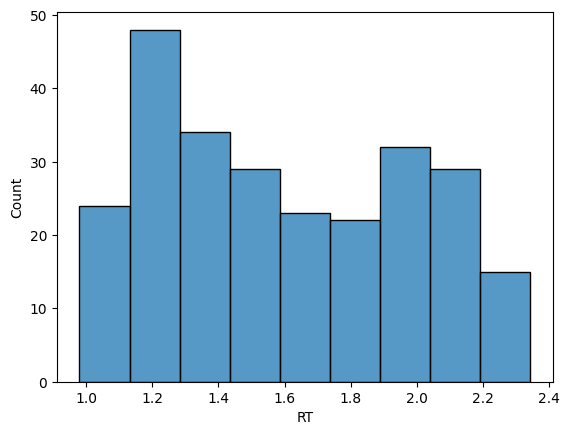

In [8]:
sns.histplot(data=sim, x="RT")

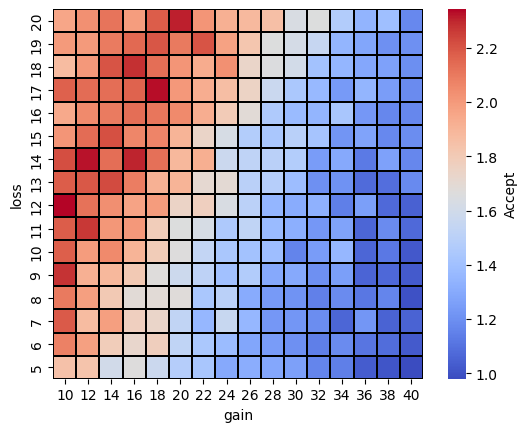

In [10]:
hmap_data = sim.groupby(['loss', 'gain'])['RT'].mean().unstack()
# Reverse the order of gain
hmap_data = hmap_data.iloc[::-1]
ax = sns.heatmap(hmap_data, cmap='coolwarm', cbar_kws={'label': 'Accept'}, square=True, linewidths=0.2, linecolor='black', cbar = True)

##### Comparison model DDM with SVs

In [47]:
x = pd.read_csv('ddm_parameters.csv').query("sub != 56").reset_index(drop=True)

In [32]:
import matplotlib.pyplot as plt
from scipy.stats import false_discovery_control
import scipy.stats as stats

In [48]:
# Rename terms in column param_names that start with "v*" to "v"
x['param_name'] = x['param_name'].str.replace(r'^v_.*', 'v', regex=True)

In [51]:
# new column that is condition. equalIndifference if sub is odd, equalRange if sub is even
x['condition'] = np.where(x['sub'] % 2 == 0, 'equalRange', 'equalIndifference')

Text(0, 0.5, 'Mean Estimate')

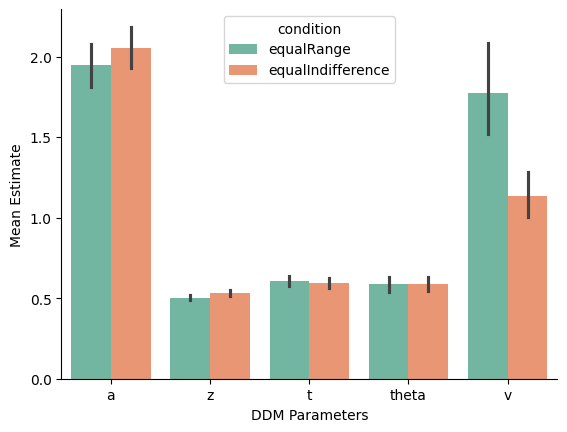

In [53]:
sns.barplot(data=x.query("param_name != 'BIC' & model_SV == 'CPT_ordinal'"), x='param_name', y='mean', hue = "condition", palette='Set2')
sns.despine()
plt.xlabel('DDM Parameters')
plt.ylabel('Mean Estimate')

In [38]:
p_values = []
t_stats = []
names = []
for i in range(4):
    for j in range(4):
        if i > j:
            model1 = x["model_SV"].unique()[i]
            model2 = x["model_SV"].unique()[j]
            data1 = x.query(f"param_name == 'BIC' & model_SV == '{model1}'").sort_values(by='sub')["mean"]
            data2 = x.query(f"param_name == 'BIC' & model_SV == '{model2}'").sort_values(by='sub')["mean"]
            t_stat, p_val = stats.ttest_rel(data1, data2)
            p_values.append(p_val)
            t_stats.append(t_stat)
            names.append(f"{model1} vs {model2}")

p_values = false_discovery_control(p_values, method = "by")
for i, name in enumerate(names):
    if p_values[i] < 0.05:
        print(f"Significant difference between {name} with p-value: {p_values[i]} and t-stat: {t_stats[i]}")

Significant difference between CPT_ordinal vs EV_ordinal with p-value: 0.0003157074876477172 and t-stat: -4.268637898917416
Significant difference between CPT_ordinal vs EV_binary with p-value: 0.0003157074876477172 and t-stat: -4.330604213045288


(375.0, 450.0)

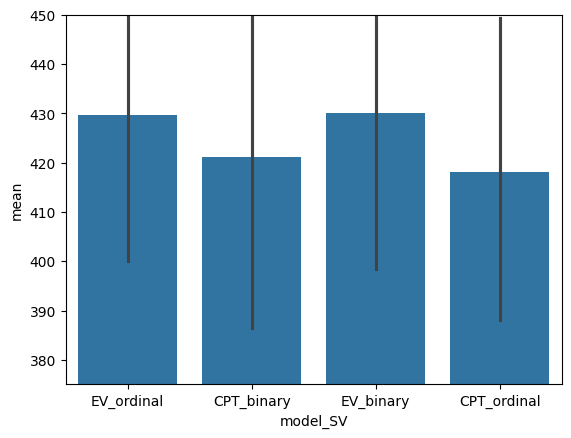

In [ ]:
sns.barplot(data=x.query("param_name == 'BIC'"), x = 'model_SV', y = 'mean')
plt.ylim(375, 450)